# UCI Online Retail Datasetを用いたアソシエーション分析

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import networkx as nx

In [3]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['font.family'] = 'Arial'

In [4]:
saved_dir = '../Results/'
random_seed = 314

In [5]:
_df = pd.read_excel('../Data/Online Retail.xlsx')
_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 前処理

In [6]:
_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


欠損値のある行を削除

In [7]:
df = _df.dropna(how='any')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


数値以外の項目についてデータ確認

In [8]:
df.describe(exclude='number')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,406829.0,406829,406829,406829,406829
unique,22190.0,3684,3896,20460,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-11-14 15:27:00,United Kingdom
freq,542.0,2077,2070,543,361878
first,NaN,NaN,NaN,2010-12-01 08:26:00,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN


国の数と種類を確認

In [9]:
df['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

合計金額を算出

In [10]:
df['TotalPrice'] = df.UnitPrice*df.Quantity

新規オーダーとキャンセルされたオーダーの情報抽出

In [11]:
df['InvoiceType'] = df['InvoiceNo'].map(lambda x: str(x)[0])
print(df['InvoiceType'].unique())

df_order = df[df['InvoiceType']=='5']
df_cancel = df[df['InvoiceType']=='C']

['5' 'C']


売上金額の描画

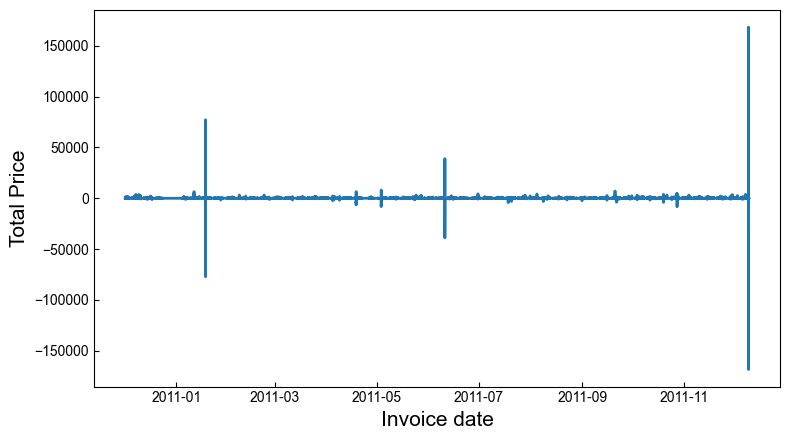

In [12]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(df['InvoiceDate'], df['TotalPrice'], linewidth=2.0)
ax.set_xlabel('Invoice date',fontsize=15)
ax.set_ylabel('Total Price',fontsize=15)
fig.tight_layout()
fig.savefig('{}InvoiceDate_TotalPrice_in_cancel.png'.format(saved_dir))
fig.show()

Total Priceがマイナスになっている行を表示

In [13]:
df.query('TotalPrice < 0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,C
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,C
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,C
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,C
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69,C
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,C
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25,C


Total Priceがマイナスになっている行のインボイスタイプを確認  
キャンセルされた注文だと分かる

In [14]:
df.query('TotalPrice < 0')['InvoiceType'].unique()

array(['C'], dtype=object)

CustomerIDを絞って購入/キャンセル履歴を見てみる．  
購入していないのにInvoiceTypeがキャンセルになっている部分がある．  
割引処理もキャンセルとなる可能性がある？

In [15]:
df.query('CustomerID == 14527.0').sort_values('InvoiceDate')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,C
8990,537159,21258,VICTORIAN SEWING BOX LARGE,3,2010-12-05 13:17:00,12.75,14527.0,United Kingdom,38.25,5
8989,537159,84997B,RED 3 PIECE RETROSPOT CUTLERY SET,2,2010-12-05 13:17:00,3.75,14527.0,United Kingdom,7.50,5
8988,537159,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET,1,2010-12-05 13:17:00,3.75,14527.0,United Kingdom,3.75,5
8987,537159,22072,RED RETROSPOT TEA CUP AND SAUCER,6,2010-12-05 13:17:00,3.75,14527.0,United Kingdom,22.50,5
...,...,...,...,...,...,...,...,...,...,...
533782,581114,22696,WICKER WREATH LARGE,1,2011-12-07 12:19:00,1.95,14527.0,United Kingdom,1.95,5
533781,581114,23344,JUMBO BAG 50'S CHRISTMAS,2,2011-12-07 12:19:00,2.08,14527.0,United Kingdom,4.16,5
533810,581114,21479,WHITE SKULL HOT WATER BOTTLE,2,2011-12-07 12:19:00,4.25,14527.0,United Kingdom,8.50,5
533795,581114,23394,POSTE FRANCE CUSHION COVER,1,2011-12-07 12:19:00,3.75,14527.0,United Kingdom,3.75,5


アルファベット1文字のStockCodeが怪しいので見てみる．  
DiscountとManualがStockCode1文字となっている．

In [16]:
df_cancel[lambda df_cancel: df_cancel['StockCode'].str.len() <= 1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50,C
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,-29.29,C
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,-281.00,C
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,-267.12,C
21758,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom,-2.00,C
...,...,...,...,...,...,...,...,...,...,...
520134,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536.0,France,-4.64,C
523375,C580510,M,Manual,-1,2011-12-04 13:48:00,1.25,14456.0,United Kingdom,-1.25,C
533082,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971.0,United Kingdom,-125.00,C
534308,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490.0,United Kingdom,-9.95,C


In [17]:
df_cancel[lambda df_cancel: df_cancel['StockCode'].str.len() <= 4]['StockCode'].unique()

array(['D', 'POST', 'M', 'C2', 'CRUK'], dtype=object)

C2も怪しかったが，これは商品名だと推測される．

In [18]:
df_cancel[lambda df_cancel: df_cancel['StockCode'].str.len() <= 4].query('StockCode == "C2"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
44302,C540164,C2,CARRIAGE,-1,2011-01-05 12:02:00,50.0,14911.0,EIRE,-50.0,C


StockCodeのDとM（DiscountとManual）を除いたCancel情報を抽出

In [19]:
df_cancel_StockCode_DandM_dropped = df_cancel.drop(df_cancel[lambda df_cancel: df_cancel['StockCode'].str.len() <= 1].index)
df_cancel_StockCode_DandM_dropped

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65,C
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,C
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
...,...,...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom,-23.40,C
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,C
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,C
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25,C


以前購入した（今回のデータには含まれていない）ものを，キャンセルしたデータも含まれている

In [20]:
df.query('CustomerID == 17548.0').sort_values(['InvoiceDate', 'StockCode']).head(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,-41.40,C
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96,C
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-39.60,C
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,C
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80,C
165027,550755,22079,RIBBON REEL HEARTS DESIGN,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom,16.50,5
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom,16.50,5
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom,16.50,5


注文情報からキャンセルされた商品を除くためのフィルター

In [21]:
df_cancel_filter = df_cancel_StockCode_DandM_dropped.filter(items=['StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'])
df_cancel_filter['Quantity_inv'] = df_cancel_filter['Quantity'] * -1
df_cancel_filter['TotalPrice_inv'] = df_cancel_filter['TotalPrice'] * -1
df_cancel_filter.drop(['Quantity', 'TotalPrice'], axis=1, inplace=True)
df_cancel_filter.rename(columns={'Quantity_inv': 'Quantity', 'TotalPrice_inv': 'TotalPrice'},inplace=True)
df_cancel_filter

,StockCode,Description,UnitPrice,CustomerID,Country,Quantity,TotalPrice
154,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65,15311.0,United Kingdom,1,4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,1.65,17548.0,United Kingdom,12,19.80
236,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29,17548.0,United Kingdom,24,6.96
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29,17548.0,United Kingdom,24,6.96
238,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29,17548.0,United Kingdom,24,6.96
...,...,...,...,...,...,...,...
540448,22178,VICTORIAN GLASS HANGING T-LIGHT,1.95,14397.0,United Kingdom,12,23.40
540449,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83,14397.0,United Kingdom,11,9.13
541715,21258,VICTORIAN SEWING BOX LARGE,10.95,15311.0,United Kingdom,5,54.75
541716,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25,17315.0,United Kingdom,1,1.25


キャンセルされずに実際に購入された商品を抽出

In [22]:
df_order_target = pd.merge(df_order,df_cancel_filter, on=['StockCode','Description','UnitPrice','CustomerID','Country','Quantity','TotalPrice'],how='outer',indicator=True).query('_merge == "left_only"')
df_order_target.drop(['_merge', 'InvoiceType'],axis=1,inplace=True)
df_order_target.sort_values('InvoiceDate', inplace=True)
df_order_target.to_csv('{}Order.csv'.format(saved_dir),index=False)
df_order_target

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
74,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
63,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
47,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
32,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
398281,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
282401,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680.0,France,19.80
259481,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France,15.00
241139,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


キャンセル注文を除いた実際の売上金額を描画．  
マイナスのデータと突出した異常なデータの多くが除去できました．  
一方で，2011年5月～2011年7月の間にある突出したデータが残っています．  

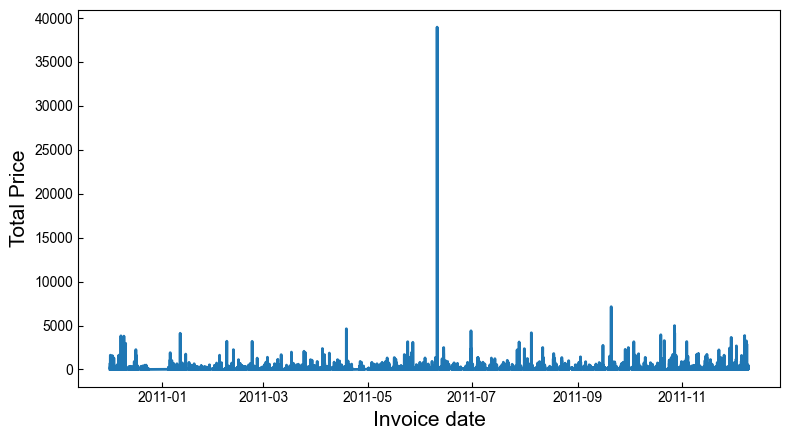

In [23]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(df_order_target['InvoiceDate'], df_order_target['TotalPrice'], linewidth=2.0)
ax.set_xlabel('Invoice date',fontsize=15)
ax.set_ylabel('Total Price',fontsize=15)
fig.tight_layout()
fig.savefig('{}InvoiceDate_TotalPrice.png'.format(saved_dir))
fig.show()

そこで，フィルターを再度考えます．  
まず，突出している部分のデータにアクセスすると，マニュアルで同じ金額が処理されていることが分かります．  
そのため，上で設計していたDとMの両方を抜いたフィルターは適切でないことが分かります．

In [24]:
df.query('CustomerID == 15098.0').sort_values('InvoiceDate')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceType
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098.0,United Kingdom,297.0,5
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.0,5
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.0,C
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom,649.5,5
222692,C556448,22502,PICNIC BASKET WICKER SMALL,-60,2011-06-10 15:39:00,4.95,15098.0,United Kingdom,-297.0,C


そこで，DもMも入れる形でCustomerID，Country，TotalPriceのみでフィルターを作りました．  

In [25]:
df_cancel_filter = df_cancel.filter(items=['StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'])
df_cancel_filter['Quantity_inv'] = df_cancel_filter['Quantity'] * -1
df_cancel_filter['TotalPrice_inv'] = df_cancel_filter['TotalPrice'] * -1
df_cancel_filter.drop(['Quantity', 'TotalPrice'], axis=1, inplace=True)
df_cancel_filter.rename(columns={'Quantity_inv': 'Quantity', 'TotalPrice_inv': 'TotalPrice'},inplace=True)
df_cancel_filter

,StockCode,Description,UnitPrice,CustomerID,Country,Quantity,TotalPrice
141,D,Discount,27.50,14527.0,United Kingdom,1,27.50
154,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65,15311.0,United Kingdom,1,4.65
235,22556,PLASTERS IN TIN CIRCUS PARADE,1.65,17548.0,United Kingdom,12,19.80
236,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29,17548.0,United Kingdom,24,6.96
237,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29,17548.0,United Kingdom,24,6.96
...,...,...,...,...,...,...,...
540449,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83,14397.0,United Kingdom,11,9.13
541541,M,Manual,224.69,15498.0,United Kingdom,1,224.69
541715,21258,VICTORIAN SEWING BOX LARGE,10.95,15311.0,United Kingdom,5,54.75
541716,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25,17315.0,United Kingdom,1,1.25


In [26]:
df_order_target = pd.merge(df_order,df_cancel_filter, on=['CustomerID','Country','TotalPrice'],how='outer',indicator=True).query('_merge == "left_only"')
df_order_target.drop(['_merge', 'InvoiceType','Description_y','UnitPrice_y','Quantity_y','StockCode_y'],axis=1,inplace=True)
df_order_target.rename(columns={'StockCode_x':'StockCode','Description_x': 'Description', 'Quantity_x': 'Quantity', 'UnitPrice_x':'UnitPrice'},inplace=True)
df_order_target.sort_values('InvoiceDate', inplace=True)
df_order_target.to_csv('{}Order.csv'.format(saved_dir),index=False)
df_order_target

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
77,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
71,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
29,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
28,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
340950,581587,22727,ALARM CLOCK BAKELIKE RED,4.0,2011-12-09 12:50:00,3.75,12680.0,France,15.00
340951,581587,22726,ALARM CLOCK BAKELIKE GREEN,4.0,2011-12-09 12:50:00,3.75,12680.0,France,15.00
340952,581587,22730,ALARM CLOCK BAKELIKE IVORY,4.0,2011-12-09 12:50:00,3.75,12680.0,France,15.00
340930,581587,22629,SPACEBOY LUNCH BOX,12.0,2011-12-09 12:50:00,1.95,12680.0,France,23.40


フィルターを使ってデータをフィルタリングして結果を描画してみると，大きなノイズは減らせているように見えます．  
厳密には，正しいフィルターでないですが，今回はこのフィルタリングしたデータを用いて分析をしていきます．

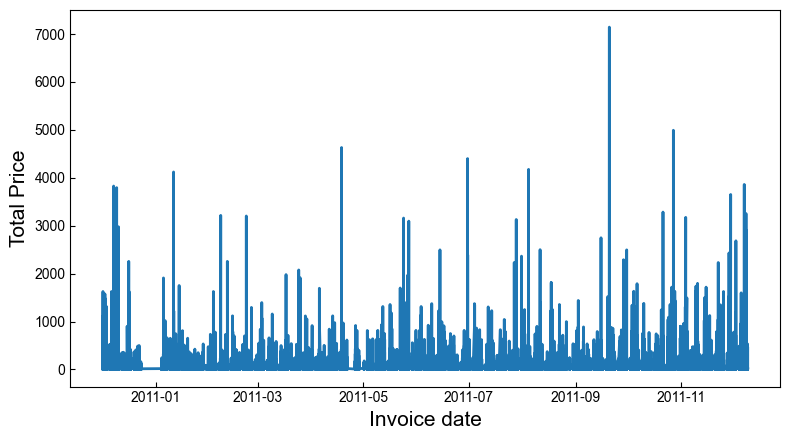

In [27]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(df_order_target['InvoiceDate'], df_order_target['TotalPrice'], linewidth=2.0)
ax.set_xlabel('Invoice date',fontsize=15)
ax.set_ylabel('Total Price',fontsize=15)
fig.tight_layout()
fig.savefig('{}InvoiceDate_TotalPrice_2.png'.format(saved_dir))
fig.show()

次にアソシエーション分析をするためにデータの整形をしていきます．

In [28]:
w1 = df.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum()
w2 = w1.unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_df = w2.apply(lambda x: x>0)
basket_df

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581484,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C581490,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C581499,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## アソシエーション分析

In [29]:
freq_items = apriori(basket_df, min_support = 0.02, use_colnames = True)
freq_items.sort_values('support', ascending = False)

,support,itemsets
153,0.089139,(85123A)
61,0.076791,(22423)
150,0.072105,(85099B)
128,0.062190,(47566)
142,0.061965,(84879)
...,...,...
68,0.020234,(22555)
54,0.020189,(22367)
165,0.020144,"(22382, 22383)"
147,0.020054,(85066)


In [30]:
a_rule = association_rules(freq_items, metric='lift',min_threshold=1)
a_rule = a_rule.sort_values('lift',ascending = False).reset_index(drop=True)
a_rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(22698),(22697),0.025056,0.031140,0.020730,0.827338,26.568210,0.019950,5.611313,0.987094
1,(22697),(22698),0.031140,0.025056,0.020730,0.665702,26.568210,0.019950,2.916390,0.993292
2,(22699),(22697),0.035286,0.031140,0.024380,0.690932,22.187826,0.023282,3.134782,0.989859
3,(22697),(22699),0.031140,0.035286,0.024380,0.782923,22.187826,0.023282,4.444115,0.985623
4,(23301),(23300),0.034069,0.028616,0.020865,0.612434,21.401429,0.019890,2.506368,0.986897
5,(23300),(23301),0.028616,0.034069,0.020865,0.729134,21.401429,0.019890,3.566081,0.981357
6,(22727),(22726),0.039522,0.035557,0.023885,0.604333,16.996386,0.022479,2.437513,0.979892
7,(22726),(22727),0.035557,0.039522,0.023885,0.671736,16.996386,0.022479,2.925934,0.975862
8,(22086),(22910),0.044164,0.031411,0.020324,0.460204,14.651261,0.018937,1.794362,0.974797
9,(22910),(22086),0.031411,0.044164,0.020324,0.647059,14.651261,0.018937,2.708202,0.961962


関係グラフの描画

In [31]:
ant = a_rule['antecedents'].values
ant_ng = []
for x in ant:
    key = tuple(x)[0]
    desc = df_order_target.query('StockCode == @key')['Description'].unique()[0]
    ant_ng.append(tuple([desc]))
#print(ant_ng)

con = a_rule['consequents'].values
con_ng = []
for x in con:
    key = tuple(x)[0]
    desc = df_order_target.query('StockCode == @key')['Description'].unique()[0]
    con_ng.append(tuple([desc]))
#print(con_ng)

both = ant_ng + con_ng
both = list(set(both))

In [32]:
G = nx.DiGraph()

for n in both:
  G.add_node(n)

for i in range(len(a_rule)):
    item = a_rule.loc[i]
    key_ant = tuple(item['antecedents'])[0]
    key_con = tuple(item['consequents'])[0]
    desc_ant = df_order_target.query('StockCode == @key_ant')['Description'].unique()[0]
    desc_con = df_order_target.query('StockCode == @key_con')['Description'].unique()[0]
    
    ant = tuple([desc_ant])
    con = tuple([desc_con])
    
    G.add_edge(ant, con)

In [33]:
pos = nx.spring_layout(G, k=2, seed=random_seed)

fig, ax = plt.subplots(figsize=(16, 9), dpi=600)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="m")
nx.draw_networkx_edges(G, pos, ax=ax,  edge_color="c", node_size=10, arrows = True, arrowstyle ='simple', arrowsize=20)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)
fig.tight_layout()
fig.savefig('{}Network.png'.format(saved_dir))
fig.show()